<a href="https://colab.research.google.com/github/bibekebib/Nepali-Letters-and-Numbers-classification-generation/blob/main/Nepali_handwriting_(Numbers)_Generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tqdm
import cv2
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!git clone https://github.com/kcnishan/Nepali_handwritten_digits_recognition.git

Cloning into 'Nepali_handwritten_digits_recognition'...
remote: Enumerating objects: 92087, done.
remote: Total 92087 (delta 0), reused 0 (delta 0), pack-reused 92087
Receiving objects: 100% (92087/92087), 67.09 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (92306/92306), done.


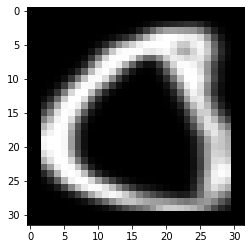

In [4]:
plt.imshow(cv2.imread('/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_0/103277.png'))

In [5]:
X_img = []
train_path = '/content/Nepali_handwritten_digits_recognition/dataset/Train/digits'
Test_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits'
for each in os.listdir('/content/Nepali_handwritten_digits_recognition/dataset/Train/digits'):
  print(each)
  for x in os.listdir(train_path+'/'+each):
    X_img.append([train_path+'/'+each+'/'+x, each])
    break

digit_5
digit_0
digit_8
digit_7
digit_1
digit_2
digit_9
digit_3
digit_6
digit_4


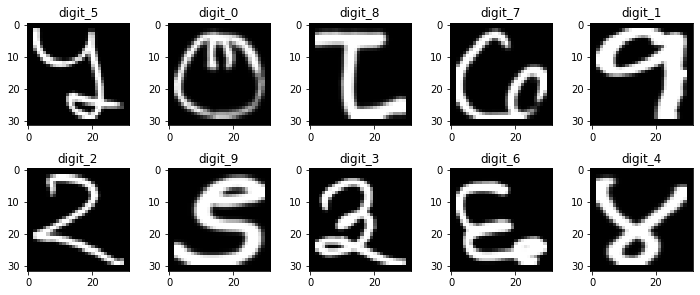

In [6]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    img = cv2.imread(X_img[i][0])
    plt.imshow(img)
    plt.title(X_img[i][1])
    plt.tight_layout(pad=1.0)
plt.show()

In [7]:
img_path = []
label = []
for each in os.listdir(train_path):
  for x in os.listdir(train_path+'/'+each):
    img_path.append(train_path+'/'+each+'/'+x)
    label.append(each)

In [8]:
img_path_test = []
label_test = []
for each in os.listdir(Test_path):
  for x in os.listdir(Test_path+'/'+each):
    img_path_test.append(Test_path+'/'+each+'/'+x)
    label_test.append(each)

In [9]:
df = pd.DataFrame(list(zip(img_path, label)), columns=['path', 'label'])

In [10]:
df_test = pd.DataFrame(list(zip(img_path_test, label_test)), columns=['path', 'label'])

In [11]:
df.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,digit_5
1,/content/Nepali_handwritten_digits_recognition...,digit_5
2,/content/Nepali_handwritten_digits_recognition...,digit_5
3,/content/Nepali_handwritten_digits_recognition...,digit_5
4,/content/Nepali_handwritten_digits_recognition...,digit_5


In [12]:
df_test.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,digit_5
1,/content/Nepali_handwritten_digits_recognition...,digit_5
2,/content/Nepali_handwritten_digits_recognition...,digit_5
3,/content/Nepali_handwritten_digits_recognition...,digit_5
4,/content/Nepali_handwritten_digits_recognition...,digit_5


In [13]:
cv2.imread(df.path[0]).shape

(32, 32, 3)

In [14]:
LbE = LabelEncoder()
df.label =  LbE.fit_transform(df.label)
df_test.label =  LbE.fit_transform(df_test.label)

In [15]:
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test

,path,label
0,/content/Nepali_handwritten_digits_recognition...,2
1,/content/Nepali_handwritten_digits_recognition...,8
2,/content/Nepali_handwritten_digits_recognition...,7
3,/content/Nepali_handwritten_digits_recognition...,2
4,/content/Nepali_handwritten_digits_recognition...,3
...,...,...
2995,/content/Nepali_handwritten_digits_recognition...,8
2996,/content/Nepali_handwritten_digits_recognition...,1
2997,/content/Nepali_handwritten_digits_recognition...,9
2998,/content/Nepali_handwritten_digits_recognition...,7


In [16]:
df = df.sample(frac=1).reset_index(drop=True)
df

,path,label
0,/content/Nepali_handwritten_digits_recognition...,3
1,/content/Nepali_handwritten_digits_recognition...,7
2,/content/Nepali_handwritten_digits_recognition...,2
3,/content/Nepali_handwritten_digits_recognition...,4
4,/content/Nepali_handwritten_digits_recognition...,5
...,...,...
16995,/content/Nepali_handwritten_digits_recognition...,4
16996,/content/Nepali_handwritten_digits_recognition...,8
16997,/content/Nepali_handwritten_digits_recognition...,5
16998,/content/Nepali_handwritten_digits_recognition...,6


In [17]:
class LetterDataset(Dataset):
  def __init__(self, df):
    self.fpath = df.path
    self.label = df.label
    self.transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),  
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
)

  def __len__(self):
    return len(self.fpath)
  
  def __getitem__(self, ix):
    img = self.fpath[ix]
    target = self.label[ix]
    img = cv2.imread(img)
    im = self.transform(img)
    return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)

In [18]:
final_df = df.append(df_test)
final_df = final_df.reset_index(drop=True)

<ipython-input-17-d7d4885211ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)


torch.Size([1, 32, 32])


Text(0.5, 1.0, "tensor(6, device='cuda:0')")

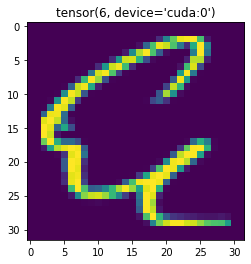

In [19]:
data =  LetterDataset(final_df)
img, label = data[100]
print(img.shape)
plt.imshow(img.cpu().reshape(32,32))
plt.title(label)

In [20]:
def conv_layer(ni, no, kernel_size, stride, padding):
  return nn.Sequential(
      nn.ConvTranspose2d(ni, no, kernel_size, stride, padding, bias=False),
      nn.BatchNorm2d(no),
      nn.ReLU(),
  )

def disc_layer(ni, no, kernel_size,  stride, padding):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride, padding, bias=False),
      nn.BatchNorm2d(no),
      nn.LeakyReLU(0.2),
  )

In [21]:
def weights_init(m):
               classname = m.__class__.__name__
               if classname.find('Conv') != -1:
                   nn.init.normal_(m.weight.data, 0.0, 0.02)
               elif classname.find('BatchNorm') != -1:
                   nn.init.normal_(m.weight.data, 1.0, 0.02)
                   nn.init.constant_(m.bias.data, 0)



class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4),
        nn.ReLU(True),
        nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*2,1,4,2,1,bias=False),
        nn.Tanh()
        )
    self.apply(weights_init)
  def forward(self,input): return self.model(input)

In [22]:
class Discriminator(nn.Module):
  def __init__(self ):
    super(Discriminator, self).__init__()
    self.disc  = nn.Sequential(
        
        #input size=32*32
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
          #16*16
        nn.LeakyReLU(0.2),
        disc_layer(64, 64*2, 4,2,1), #8x8
        disc_layer(64*2, 64*4, 4,2,1),#4x4
        nn.Conv2d(64*4, 1, kernel_size=4,stride=2,padding=0),#1x1
        nn.Sigmoid()
    )

    self.apply(weights_init)
  def forward(self, input):
    return self.disc(input)

In [23]:
z_dim =100
H,W = 32,32
N = 8
disc = Discriminator().to(device)
gen = Generator().to(device)


In [24]:
from torchsummary import summary
summary(gen,(100,1,1),1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [1, 512, 4, 4]         819,200
       BatchNorm2d-2             [1, 512, 4, 4]           1,024
              ReLU-3             [1, 512, 4, 4]               0
   ConvTranspose2d-4             [1, 256, 8, 8]       2,097,152
       BatchNorm2d-5             [1, 256, 8, 8]             512
              ReLU-6             [1, 256, 8, 8]               0
   ConvTranspose2d-7           [1, 128, 16, 16]         524,288
       BatchNorm2d-8           [1, 128, 16, 16]             256
              ReLU-9           [1, 128, 16, 16]               0
  ConvTranspose2d-10             [1, 1, 32, 32]           2,048
             Tanh-11             [1, 1, 32, 32]               0
Total params: 3,444,480
Trainable params: 3,444,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [25]:
def calculateHWOUT(H_in, W_IN, padding, kernel_size, stride, max_pool_num):
    H_out = (((H_in + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    W_out = (((W_IN + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    return (int(H_out), int(W_out))
calculateHWOUT(4,4,1,4,2,1)

(2, 2)

In [26]:
def label_real(size):
  data = torch.ones(size)
  return data.to(device)

def label_fake(size):
  data = torch.zeros(size)
  return data.to(device)

In [27]:
def create_noise(N,z_dim):
  return torch.randn(N, z_dim,1,1).to(device)

In [28]:
# def save_generator_image(image, path):
#   save_image(image, path, normalize=True)

In [29]:
image_size = 32
batch_size = 32
z_dim =100
beta1 = 0.5
lr=0.0002
epochs = 25
sample_size=8

In [30]:
def get_data():
  data =  LetterDataset(final_df)
  trn_ldr = DataLoader(data, batch_size=batch_size, shuffle=True)
  return trn_ldr

In [31]:
trn_ldr = get_data()

In [32]:
loss_fn = nn.BCELoss()
optimizer_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

In [33]:
losses_g = []
losses_d = []

In [34]:
# def train_disc(optimizer, data_real, data_fake):

#   b_size = len(data_real)
#   real_label = label_real(b_size).squeeze()
#   fake_label = label_fake(b_size)

#   optimizer.zero_grad()

#   output_real = disc(data_real).squeeze()
  
#   print(output_real.shape)
#   print('****')
#   print(real_label.shape)
#   loss_real = loss_fn(output_real, real_label)
#   # print(data_fake.shape)
#   output_fake = disc(data_fake)
#   loss_fake = loss_fn(output_fake, fake_label)

#   loss_real.backward()
#   loss_fake.backward()

#   optimizer.step()

#   return (loss_real + loss_fake)


def train_disc(optimizer,real_data, fake_data):
               optimizer.zero_grad()
               prediction_real = disc(real_data)
               error_real = loss_fn(prediction_real.squeeze(), \
                                 torch.ones(len(real_data)).to(device))
               error_real.backward()
               prediction_fake = disc(fake_data)
               error_fake = loss_fn(prediction_fake.squeeze(), \
                                 torch.zeros(len(fake_data)).to(device))
               error_fake.backward()
               optimizer.step()
               return error_real + error_fake

In [35]:
  def train_gen(optimizer,fake_data):
               optimizer.zero_grad()
               prediction = disc(fake_data)
               error = loss_fn(prediction.squeeze(), \
                            torch.ones(len(fake_data)).to(device))
               error.backward()
               optimizer.step()
               return error

In [36]:
gen.train()
disc.train()
noise = create_noise(sample_size, z_dim)

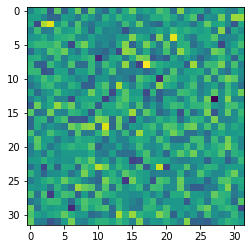

In [37]:
a = torch.randn(8,1,32,32)
plt.imshow(a[0].reshape(32,32))

Epoch: _________*****0*****_______


0it [00:00, ?it/s]<ipython-input-17-d7d4885211ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)
625it [00:27, 23.14it/s]


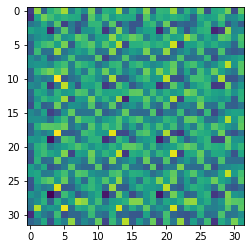

tensor(1188.9226, device='cuda:0', grad_fn=<AddBackward0>) tensor(646.4234, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****0 Generator Training Loss : 1.9053246974945068 *****_______
Epoch: _________*****0 Discriminator Training Loss : 1.0359349250793457 *****_______
Epoch: _________*****1*****_______


625it [00:22, 27.58it/s]


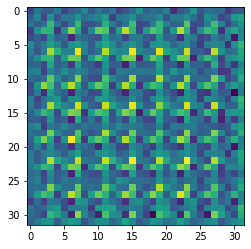

tensor(491.0830, device='cuda:0', grad_fn=<AddBackward0>) tensor(866.7609, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****1 Generator Training Loss : 0.7869920134544373 *****_______
Epoch: _________*****1 Discriminator Training Loss : 1.3890398740768433 *****_______
Epoch: _________*****2*****_______


625it [00:23, 26.34it/s]


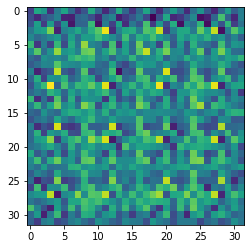

tensor(441.1385, device='cuda:0', grad_fn=<AddBackward0>) tensor(872.3536, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****2 Generator Training Loss : 0.7069527506828308 *****_______
Epoch: _________*****2 Discriminator Training Loss : 1.3980026245117188 *****_______
Epoch: _________*****3*****_______


625it [00:23, 27.17it/s]


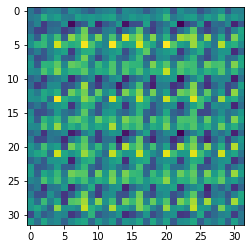

tensor(436.1263, device='cuda:0', grad_fn=<AddBackward0>) tensor(870.1250, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****3 Generator Training Loss : 0.6989203095436096 *****_______
Epoch: _________*****3 Discriminator Training Loss : 1.3944311141967773 *****_______
Epoch: _________*****4*****_______


625it [00:26, 23.40it/s]


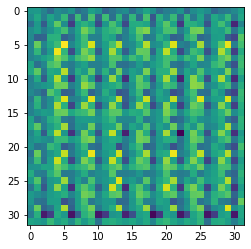

tensor(437.0546, device='cuda:0', grad_fn=<AddBackward0>) tensor(870.4286, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****4 Generator Training Loss : 0.7004079818725586 *****_______
Epoch: _________*****4 Discriminator Training Loss : 1.394917607307434 *****_______
Epoch: _________*****5*****_______


625it [00:24, 25.36it/s]


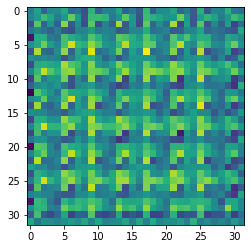

tensor(436.5150, device='cuda:0', grad_fn=<AddBackward0>) tensor(869.9500, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****5 Generator Training Loss : 0.6995433568954468 *****_______
Epoch: _________*****5 Discriminator Training Loss : 1.394150733947754 *****_______
Epoch: _________*****6*****_______


625it [00:22, 27.27it/s]


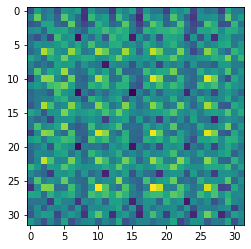

tensor(437.2763, device='cuda:0', grad_fn=<AddBackward0>) tensor(869.9194, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****6 Generator Training Loss : 0.7007633447647095 *****_______
Epoch: _________*****6 Discriminator Training Loss : 1.394101619720459 *****_______
Epoch: _________*****7*****_______


625it [00:22, 27.24it/s]


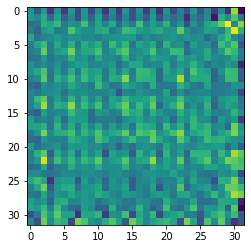

tensor(2532.0596, device='cuda:0', grad_fn=<AddBackward0>) tensor(399.9025, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****7 Generator Training Loss : 4.057787895202637 *****_______
Epoch: _________*****7 Discriminator Training Loss : 0.6408694386482239 *****_______
Epoch: _________*****8*****_______


625it [00:22, 27.32it/s]


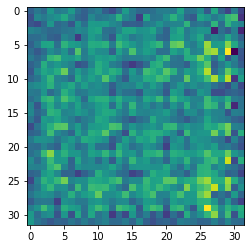

tensor(910.1381, device='cuda:0', grad_fn=<AddBackward0>) tensor(795.7554, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****8 Generator Training Loss : 1.458554744720459 *****_______
Epoch: _________*****8 Discriminator Training Loss : 1.2752490043640137 *****_______
Epoch: _________*****9*****_______


625it [00:22, 27.18it/s]


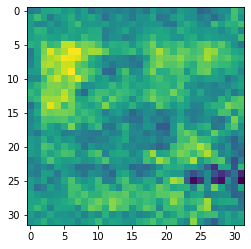

tensor(1217.9672, device='cuda:0', grad_fn=<AddBackward0>) tensor(636.3494, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****9 Generator Training Loss : 1.9518704414367676 *****_______
Epoch: _________*****9 Discriminator Training Loss : 1.019790768623352 *****_______
Epoch: _________*****10*****_______


625it [00:22, 27.20it/s]


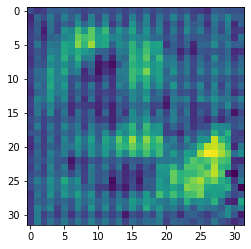

tensor(791.1606, device='cuda:0', grad_fn=<AddBackward0>) tensor(716.8357, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****10 Generator Training Loss : 1.267885684967041 *****_______
Epoch: _________*****10 Discriminator Training Loss : 1.1487752199172974 *****_______
Epoch: _________*****11*****_______


625it [00:23, 27.00it/s]


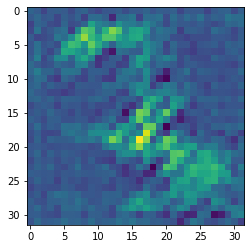

tensor(1092.5881, device='cuda:0', grad_fn=<AddBackward0>) tensor(522.4713, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****11 Generator Training Loss : 1.750942587852478 *****_______
Epoch: _________*****11 Discriminator Training Loss : 0.837293803691864 *****_______
Epoch: _________*****12*****_______


625it [00:23, 26.59it/s]


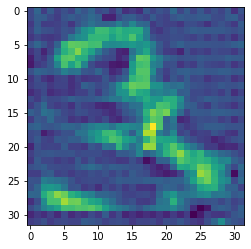

tensor(1231.0933, device='cuda:0', grad_fn=<AddBackward0>) tensor(418.2965, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****12 Generator Training Loss : 1.9729058742523193 *****_______
Epoch: _________*****12 Discriminator Training Loss : 0.6703470349311829 *****_______
Epoch: _________*****13*****_______


625it [00:23, 27.00it/s]


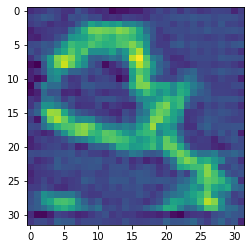

tensor(1415.9926, device='cuda:0', grad_fn=<AddBackward0>) tensor(330.6292, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****13 Generator Training Loss : 2.269218921661377 *****_______
Epoch: _________*****13 Discriminator Training Loss : 0.529854416847229 *****_______
Epoch: _________*****14*****_______


625it [00:23, 27.05it/s]


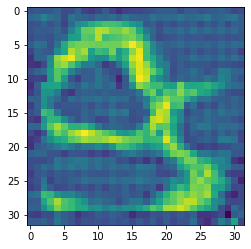

tensor(1595.0537, device='cuda:0', grad_fn=<AddBackward0>) tensor(289.0320, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****14 Generator Training Loss : 2.556175947189331 *****_______
Epoch: _________*****14 Discriminator Training Loss : 0.4631922245025635 *****_______
Epoch: _________*****15*****_______


625it [00:23, 27.13it/s]


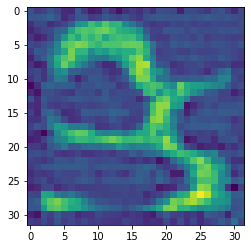

tensor(1738.1979, device='cuda:0', grad_fn=<AddBackward0>) tensor(259.1790, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****15 Generator Training Loss : 2.7855734825134277 *****_______
Epoch: _________*****15 Discriminator Training Loss : 0.41535088419914246 *****_______
Epoch: _________*****16*****_______


625it [00:22, 27.22it/s]


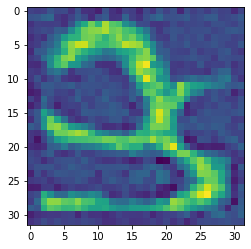

tensor(1990.1469, device='cuda:0', grad_fn=<AddBackward0>) tensor(196.1847, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****16 Generator Training Loss : 3.189337968826294 *****_______
Epoch: _________*****16 Discriminator Training Loss : 0.31439852714538574 *****_______
Epoch: _________*****17*****_______


625it [00:23, 27.12it/s]


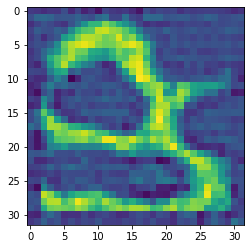

tensor(1941.5585, device='cuda:0', grad_fn=<AddBackward0>) tensor(247.4197, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****17 Generator Training Loss : 3.1114718914031982 *****_______
Epoch: _________*****17 Discriminator Training Loss : 0.39650586247444153 *****_______
Epoch: _________*****18*****_______


625it [00:27, 22.88it/s]


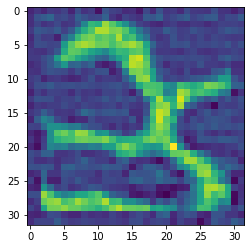

tensor(2167.1599, device='cuda:0', grad_fn=<AddBackward0>) tensor(177.7977, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****18 Generator Training Loss : 3.473012685775757 *****_______
Epoch: _________*****18 Discriminator Training Loss : 0.2849321663379669 *****_______
Epoch: _________*****19*****_______


625it [00:23, 26.63it/s]


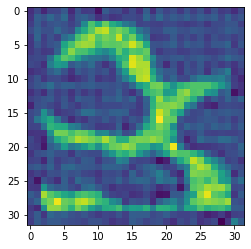

tensor(2258.3655, device='cuda:0', grad_fn=<AddBackward0>) tensor(158.0965, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****19 Generator Training Loss : 3.619175434112549 *****_______
Epoch: _________*****19 Discriminator Training Loss : 0.2533597946166992 *****_______
Epoch: _________*****20*****_______


625it [00:23, 26.90it/s]


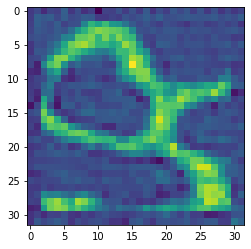

tensor(2141.2979, device='cuda:0', grad_fn=<AddBackward0>) tensor(239.1194, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****20 Generator Training Loss : 3.4315671920776367 *****_______
Epoch: _________*****20 Discriminator Training Loss : 0.3832041621208191 *****_______
Epoch: _________*****21*****_______


625it [00:27, 23.07it/s]


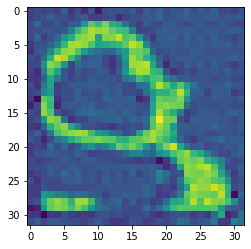

tensor(2431.2302, device='cuda:0', grad_fn=<AddBackward0>) tensor(143.6557, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****21 Generator Training Loss : 3.896202325820923 *****_______
Epoch: _________*****21 Discriminator Training Loss : 0.23021744191646576 *****_______
Epoch: _________*****22*****_______


625it [00:27, 22.90it/s]


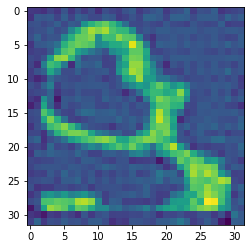

tensor(2400.6355, device='cuda:0', grad_fn=<AddBackward0>) tensor(171.6389, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****22 Generator Training Loss : 3.847172260284424 *****_______
Epoch: _________*****22 Discriminator Training Loss : 0.2750622630119324 *****_______
Epoch: _________*****23*****_______


625it [00:23, 26.43it/s]


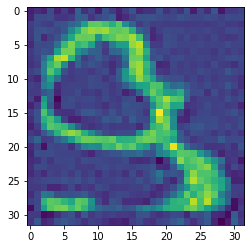

tensor(2483.5066, device='cuda:0', grad_fn=<AddBackward0>) tensor(171.0717, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****23 Generator Training Loss : 3.979978561401367 *****_______
Epoch: _________*****23 Discriminator Training Loss : 0.2741534411907196 *****_______
Epoch: _________*****24*****_______


625it [00:23, 27.09it/s]


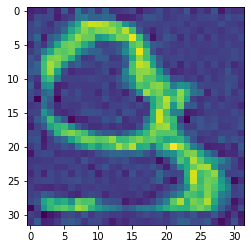

tensor(2578.9504, device='cuda:0', grad_fn=<AddBackward0>) tensor(132.2317, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****24 Generator Training Loss : 4.132933616638184 *****_______
Epoch: _________*****24 Discriminator Training Loss : 0.21190981566905975 *****_______
Epoch: _________*****25*****_______


625it [00:23, 27.05it/s]


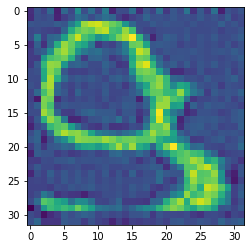

tensor(2608.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(153.8833, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****25 Generator Training Loss : 4.180288314819336 *****_______
Epoch: _________*****25 Discriminator Training Loss : 0.24660789966583252 *****_______
Epoch: _________*****26*****_______


625it [00:24, 25.46it/s]


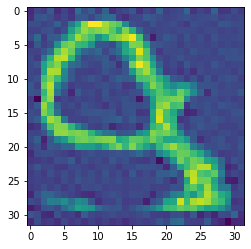

tensor(2695.4766, device='cuda:0', grad_fn=<AddBackward0>) tensor(134.0421, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****26 Generator Training Loss : 4.319674015045166 *****_______
Epoch: _________*****26 Discriminator Training Loss : 0.21481108665466309 *****_______
Epoch: _________*****27*****_______


625it [00:23, 27.05it/s]


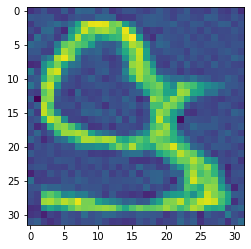

tensor(2655.9609, device='cuda:0', grad_fn=<AddBackward0>) tensor(156.9172, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****27 Generator Training Loss : 4.25634765625 *****_______
Epoch: _________*****27 Discriminator Training Loss : 0.2514699101448059 *****_______
Epoch: _________*****28*****_______


625it [00:23, 27.08it/s]


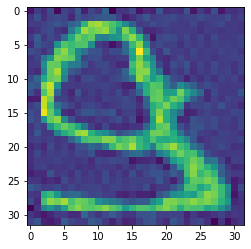

tensor(2881.3459, device='cuda:0', grad_fn=<AddBackward0>) tensor(105.2464, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****28 Generator Training Loss : 4.617541790008545 *****_______
Epoch: _________*****28 Discriminator Training Loss : 0.16866403818130493 *****_______
Epoch: _________*****29*****_______


625it [00:26, 23.49it/s]


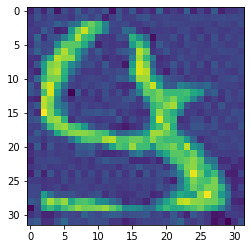

tensor(2652.5088, device='cuda:0', grad_fn=<AddBackward0>) tensor(166.9968, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****29 Generator Training Loss : 4.250815391540527 *****_______
Epoch: _________*****29 Discriminator Training Loss : 0.26762309670448303 *****_______
Epoch: _________*****30*****_______


625it [00:23, 26.98it/s]


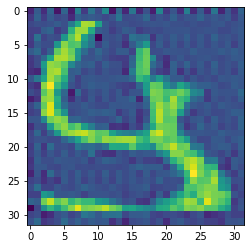

tensor(3003.4609, device='cuda:0', grad_fn=<AddBackward0>) tensor(117.1431, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****30 Generator Training Loss : 4.813238620758057 *****_______
Epoch: _________*****30 Discriminator Training Loss : 0.18772926926612854 *****_______
Epoch: _________*****31*****_______


625it [00:23, 26.91it/s]


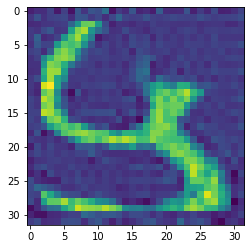

tensor(3064.3928, device='cuda:0', grad_fn=<AddBackward0>) tensor(76.4451, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****31 Generator Training Loss : 4.910885810852051 *****_______
Epoch: _________*****31 Discriminator Training Loss : 0.12250813841819763 *****_______
Epoch: _________*****32*****_______


625it [00:23, 26.72it/s]


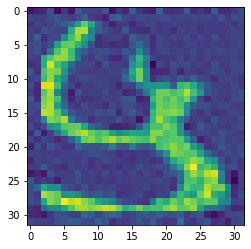

tensor(3063.5420, device='cuda:0', grad_fn=<AddBackward0>) tensor(107.5867, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****32 Generator Training Loss : 4.909522533416748 *****_______
Epoch: _________*****32 Discriminator Training Loss : 0.1724146604537964 *****_______
Epoch: _________*****33*****_______


625it [00:23, 26.93it/s]


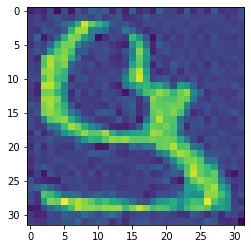

tensor(3238.0696, device='cuda:0', grad_fn=<AddBackward0>) tensor(95.2211, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****33 Generator Training Loss : 5.18921422958374 *****_______
Epoch: _________*****33 Discriminator Training Loss : 0.15259791910648346 *****_______
Epoch: _________*****34*****_______


625it [00:23, 26.06it/s]


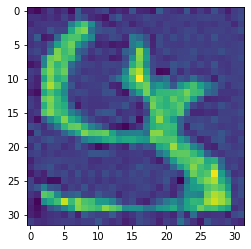

tensor(2916.9683, device='cuda:0', grad_fn=<AddBackward0>) tensor(150.3455, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****34 Generator Training Loss : 4.674628734588623 *****_______
Epoch: _________*****34 Discriminator Training Loss : 0.24093826115131378 *****_______
Epoch: _________*****35*****_______


625it [00:23, 26.96it/s]


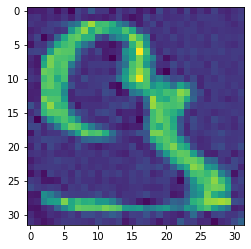

tensor(3088.0642, device='cuda:0', grad_fn=<AddBackward0>) tensor(103.0704, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****35 Generator Training Loss : 4.948821067810059 *****_______
Epoch: _________*****35 Discriminator Training Loss : 0.1651768982410431 *****_______
Epoch: _________*****36*****_______


625it [00:23, 26.87it/s]


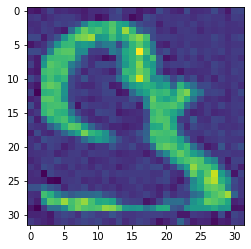

tensor(3192.2361, device='cuda:0', grad_fn=<AddBackward0>) tensor(103.1099, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****36 Generator Training Loss : 5.115763187408447 *****_______
Epoch: _________*****36 Discriminator Training Loss : 0.16524028778076172 *****_______
Epoch: _________*****37*****_______


625it [00:23, 26.80it/s]


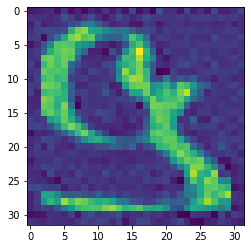

tensor(3115.3354, device='cuda:0', grad_fn=<AddBackward0>) tensor(115.6942, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****37 Generator Training Loss : 4.99252462387085 *****_______
Epoch: _________*****37 Discriminator Training Loss : 0.18540744483470917 *****_______
Epoch: _________*****38*****_______


625it [00:23, 26.89it/s]


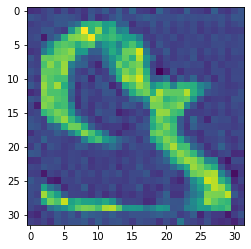

tensor(3342.8799, device='cuda:0', grad_fn=<AddBackward0>) tensor(102.7057, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****38 Generator Training Loss : 5.357179164886475 *****_______
Epoch: _________*****38 Discriminator Training Loss : 0.16459238529205322 *****_______
Epoch: _________*****39*****_______


625it [00:23, 26.51it/s]


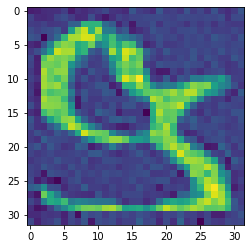

tensor(3463.6057, device='cuda:0', grad_fn=<AddBackward0>) tensor(63.1051, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****39 Generator Training Loss : 5.550650119781494 *****_______
Epoch: _________*****39 Discriminator Training Loss : 0.10112995654344559 *****_______
Epoch: _________*****40*****_______


625it [00:24, 25.63it/s]


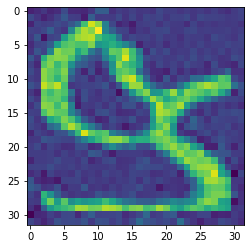

tensor(3411.6536, device='cuda:0', grad_fn=<AddBackward0>) tensor(111.6716, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****40 Generator Training Loss : 5.467393398284912 *****_______
Epoch: _________*****40 Discriminator Training Loss : 0.17896093428134918 *****_______
Epoch: _________*****41*****_______


625it [00:23, 26.79it/s]


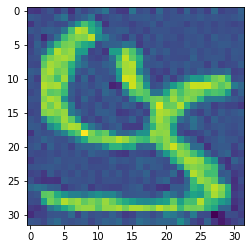

tensor(3103.2078, device='cuda:0', grad_fn=<AddBackward0>) tensor(112.4955, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****41 Generator Training Loss : 4.973089218139648 *****_______
Epoch: _________*****41 Discriminator Training Loss : 0.18028132617473602 *****_______
Epoch: _________*****42*****_______


625it [00:23, 26.77it/s]


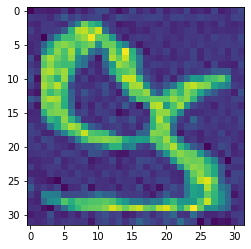

tensor(3500.2373, device='cuda:0', grad_fn=<AddBackward0>) tensor(69.8279, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****42 Generator Training Loss : 5.609354496002197 *****_______
Epoch: _________*****42 Discriminator Training Loss : 0.1119036078453064 *****_______
Epoch: _________*****43*****_______


625it [00:23, 26.55it/s]


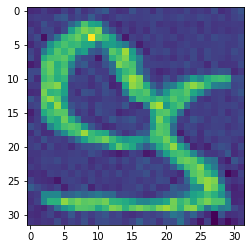

tensor(2986.5940, device='cuda:0', grad_fn=<AddBackward0>) tensor(149.5031, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****43 Generator Training Loss : 4.786208152770996 *****_______
Epoch: _________*****43 Discriminator Training Loss : 0.23958823084831238 *****_______
Epoch: _________*****44*****_______


625it [00:23, 26.44it/s]


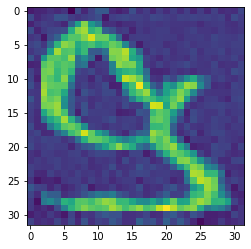

tensor(3298.4624, device='cuda:0', grad_fn=<AddBackward0>) tensor(100.0031, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****44 Generator Training Loss : 5.28599739074707 *****_______
Epoch: _________*****44 Discriminator Training Loss : 0.16026142239570618 *****_______
Epoch: _________*****45*****_______


625it [00:23, 26.58it/s]


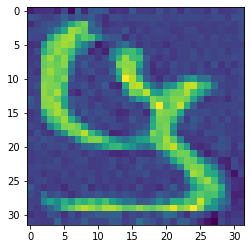

tensor(3564.8816, device='cuda:0', grad_fn=<AddBackward0>) tensor(74.5506, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****45 Generator Training Loss : 5.712951183319092 *****_______
Epoch: _________*****45 Discriminator Training Loss : 0.11947204917669296 *****_______
Epoch: _________*****46*****_______


625it [00:23, 26.26it/s]


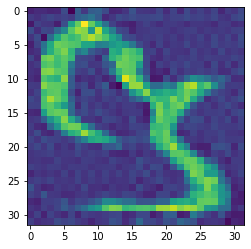

tensor(3635.3914, device='cuda:0', grad_fn=<AddBackward0>) tensor(74.9758, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****46 Generator Training Loss : 5.8259477615356445 *****_______
Epoch: _________*****46 Discriminator Training Loss : 0.12015348672866821 *****_______
Epoch: _________*****47*****_______


625it [00:23, 26.57it/s]


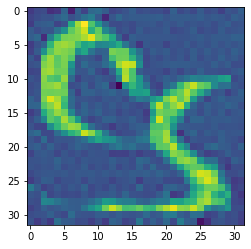

tensor(3211.3799, device='cuda:0', grad_fn=<AddBackward0>) tensor(127.9813, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****47 Generator Training Loss : 5.146442413330078 *****_______
Epoch: _________*****47 Discriminator Training Loss : 0.20509816706180573 *****_______
Epoch: _________*****48*****_______


625it [00:23, 26.72it/s]


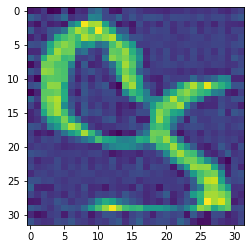

tensor(3919.4453, device='cuda:0', grad_fn=<AddBackward0>) tensor(52.2376, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****48 Generator Training Loss : 6.281162261962891 *****_______
Epoch: _________*****48 Discriminator Training Loss : 0.08371413499116898 *****_______
Epoch: _________*****49*****_______


625it [00:23, 26.66it/s]


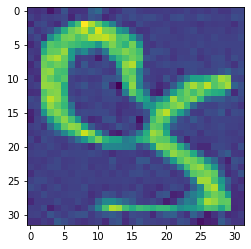

tensor(3842.2698, device='cuda:0', grad_fn=<AddBackward0>) tensor(36.2885, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: _________*****49 Generator Training Loss : 6.1574835777282715 *****_______
Epoch: _________*****49 Discriminator Training Loss : 0.05815466493368149 *****_______


In [38]:
for i in range(50):
  loss_g = 0.0
  loss_d = 0.0
  print(f'Epoch: _________*****{i}*****_______')
  for ix, batch in tqdm.tqdm(enumerate((trn_ldr))):
    x, y = batch
    x = x.to(device)
    b_size = len(x)
    data_fake = gen(create_noise(b_size, z_dim)).detach()
    data_real = x
    loss_d +=train_disc(optimizer_d, data_real, data_fake)
    data_fake = gen(create_noise(b_size, z_dim))
    loss_g += train_gen(optimizer_g,data_fake)
  generated_image = gen(noise).cpu().detach()
  plt.imshow(generated_image[0].reshape(32,32))
  plt.show()
  print(loss_g, loss_d)
  epoch_loss_g = (loss_g / ix)
  epoch_loss_d = loss_d / ix
  losses_g.append(epoch_loss_g)
  losses_d.append(epoch_loss_d)
  print(f'Epoch: _________*****{i} Generator Training Loss : {epoch_loss_g} *****_______')
  print(f'Epoch: _________*****{i} Discriminator Training Loss : {epoch_loss_d} *****_______')

  

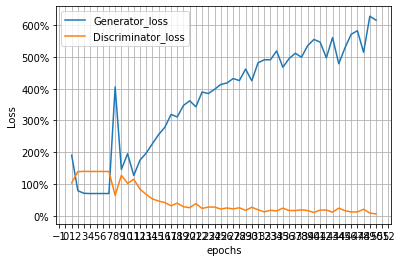

In [51]:
epochs = np.arange(50) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, torch.tensor(losses_g, device='cpu'), label='Generator_loss')
plt.plot(epochs, torch.tensor(losses_d).cpu(), label='Discriminator_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
# plt.title('Training and Validation accuracy with 17000 data points used for training')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

In [52]:
torch.save(gen.state_dict(), 'gen.pth')

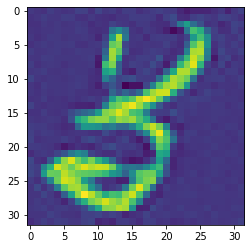

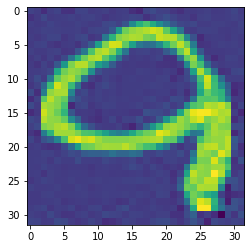

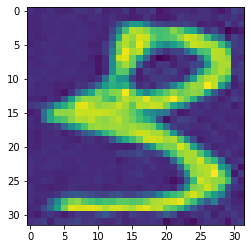

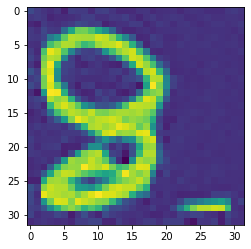

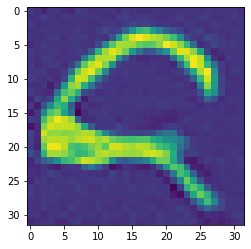

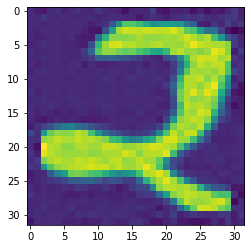

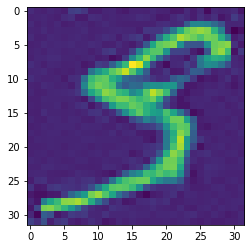

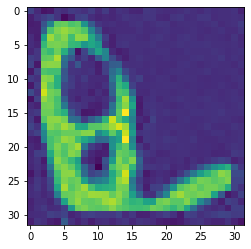

In [55]:
generated_img =  gen(create_noise(8, z_dim)).cpu().detach()
for i in range(len(generated_img)):
  plt.imshow(generated_img[i].reshape(32,32))
  plt.show()

In [ ]:
def preprocess_predict_data(img_path):
  img = cv2.imread(img_path)
  transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),  
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
  )
  img = transform(img).to(device)
  return img

def predict(x, model):
  img = preprocess_predict_data(x)
  img = img.unsqueeze_(0)
  pred = model(img)
  return torch.max(pred.data, 1)

In [ ]:
img = 

In [ ]:
img_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_4/40846.png'
# img = preprocess_predict_data(img_path)
pred = predict(img_path, model)
pred

In [ ]:
img_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_7/10215.png'
pred = predict(img_path, model)
pred